# 2つのガウス分布を含む混合ガウス分布のためのEMアルゴリズム

（細かいコメントはもうちょっと待ってくださーい）

千葉工業大学 上田 隆一

(c) 2017 Ryuichi Ueda

This software is released under the MIT License, see LICENSE.

## はじめに

このコードは、2つの2次元ガウス分布を含む混合ガウス分布から生成されたデータについて、EMアルゴリズムでパラメータを求めるためのEMアルゴリズムの実装例です。処理の流れは、次のようなものです。

* （準備）2つのガウス分布からサンプリング
  * 推定対象は、この2つのガウス分布のパラメータと、どちらからどれだけサンプリングされたかの比
* 適当なパラメータで2つガウス分布を準備し、収束するまで以下の繰り返し
  * Eステップ: 各サンプルがどちらの分布から生成されたらしいかを、2つのガウス分布の確率密度関数から得られる値の比で計算
  * Mステップ: Eステップで得た比を利用して、推定対象の値を計算
* 収束したら、推定値を出力

## アルゴリズムを適用される対象になるデータの生成

クラスタリングの対象となるデータを作ります。二つの2次元ガウス分布から、2:1の割合で標本抽出します。（GitHubだと行列が崩れて表示されますが、$\mathcal{N}$の二番目の引数は2x2行列です。）

* 2つの分布
  * 分布A（200個抽出）: $\mathcal{N}\left( \begin{bmatrix}170 \\ 70 \end{bmatrix}, \begin{bmatrix}6^2 & -30 \\ -30 &  8^2\end{bmatrix} \right)$
  * 分布B（100個抽出）: $\mathcal{N}\left( \begin{bmatrix}165 \\ 50 \end{bmatrix}, \begin{bmatrix}5^2 & 20 \\ 20 &  6^2\end{bmatrix} \right)$

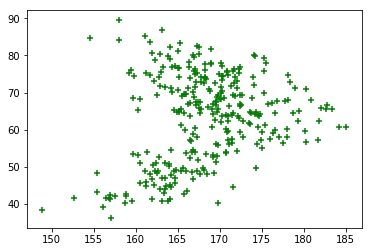

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

def make_samples():
    # グループAのガウス分布
    muA_ans = [170,70]                                 # 横軸、縦軸をx,y軸とすると、x=170, y=70が中心
    covA_ans = [[6**2,-30],[-30,8**2]]      # x軸の標準偏差6、y軸の標準偏差-30、共分散-30
    samplesA = np.random.multivariate_normal(muA_ans,covA_ans,200).T #200個の点をサンプリング

    # グループBのガウス分布
    muB_ans = [165,50]                                # x=165, y=50が中心
    covB_ans = [[5.**2,20],[20,6**2]]       # x軸の標準偏差5、y軸の標準偏差6、共分散20
    samplesB = np.random.multivariate_normal(muB_ans,covB_ans,100).T #100個の点をサンプリング

    # 2つのグループのリストをくっつけて返す
    return np.column_stack((samplesA,samplesB))

# データを作る
samples = make_samples()

#描画してみましょう
plt.scatter(samples[0],samples[1],color='g',marker='+')   # sample[0]がx値のずらっと入ったリスト、sample[1]がy値

# このデータに関する既知のパラメータ
K = 2 # クラスタの数
N = len(samples[0]) # サンプルの数


  
以後、サンプルは$\boldsymbol{x}_n = (x_n,y_n) \quad (n=0,1,2,\dots,N)$と表現します。

## パラメータの初期設定

2つの分布のパラメータを格納する変数を準備して、このパラメータを上記の分布の式に近づけていきます。また、混合係数の変数も準備します。混合係数というのは、どっちからどれだけサンプルが生成されたかの割合のことです。上の例だと分布1で$2/3$、分布2で$1/3$となります。

* パラメータ
  * 各分布(リストdistributions): $\mathcal{N}(\boldsymbol{x} | \boldsymbol{\mu}_k, \Sigma_k)\quad (k=0,1)$
  * 混合係数（リストmixing_coefs）: $\pi_k \quad (k=0,1; \pi_0 + \pi_1 = 1)$

In [2]:
from scipy.stats import multivariate_normal          # これを使うと多次元ガウス分布のオブジェクトが生成できます

# 2つのガウス分布のオブジェクトを作る
distributions = []
distributions.append(multivariate_normal(mean=[160,80],cov= [[100,0],[0,100]]) )   # 分布1を適当な分布の中心、共分散行列で初期化
distributions.append(multivariate_normal(mean=[170,100],cov= [[100,0],[0,100]]) )   # 分布2を同様に初期化。分布1と少し値を変える必要アリ

# 混合係数のリスト
mixing_coefs = [1.0/K for k in range(K)]   # 回りくどい書き方をしていますが、両方0.5で初期化されます。

描画の関係でサンプルの分布に重なるようにガウス分布を初期化していますが、辺鄙な値でも大丈夫です。

## 描画用の関数

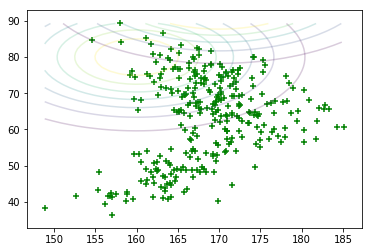

In [3]:
def draw(ds,X):
    # 分布を等高線で描画
    x, y = np.mgrid[(min(X[0])):(max(X[0])):1, (min(X[1])):(max(X[1])):1]   # 描画範囲の指定
    for d in ds:
        pos = np.empty(x.shape + (2,))
        pos[:, :, 0] = x; pos[:, :, 1] = y
        plt.contour(x, y, d.pdf(pos),alpha=0.2)
        
    # サンプルの描画
    plt.scatter(X[0],X[1],color='g',marker='+')
    
draw(distributions,samples)

以後、描かれた2つの楕円がサンプルの上に重なるように計算していきます。

## Eステップの実装

分布を固定し、各サンプルがどっちの分布に属すかを表した確率である負担率$\gamma(z_{nk})$のリストを各サンプル、各分布に対して計算して返します。

$\gamma(z_{nk}) = \dfrac{\pi_k \mathcal{N}(\boldsymbol{x}_n | \boldsymbol{\mu}_k, \Sigma_k)
}{\sum_j^K\pi_j \mathcal{N}(\boldsymbol{x}_n | \boldsymbol{\mu}_j, \Sigma_j)}$

In [4]:
def expectation_step(ds,X,pis):    # 負担率の計算
    ans = [] # 負担率のリスト
    for n in range(N): # サンプルの数だけ繰り返し
        # サンプルの地点における各分布の値（密度）を計算
        ws = [ pis[k] * ds[k].pdf([X[0][n],X[1][n]]) for k in range(K) ]  # 各クラスタに対して負担率の分子を計算
        ans.append([ws[k]/sum(ws) for k in range(K)])                           # 各クラスタの負担率の合計が1になるように正規化しているだけ

    return ans                                      # K * N 個のリスト

## Mステップの実装

各分布のパラメータと混合係数を更新します。次のコードの2行目の$N_k = \sum_{n=0}^{N-1} \gamma(z_{nk}) $は、各分布に関する全サンプルの負担率を合計して、各分布に「いくつ」サンプルが所属するかを求めたものです。負担率はゼロイチではないので、$N_k$は小数になります。



* 分布の中心の更新: $\boldsymbol{\mu}_k \longleftarrow \dfrac{1}{N_k} \sum_{n=0}^{N-1} \gamma(z_{nk})\boldsymbol{x}_n$
* 分布の共分散行列の更新: $\Sigma_k \longleftarrow \dfrac{1}{N_k} \sum_{n=0}^{N-1} \gamma(z_{nk}) (\boldsymbol{x}_n - \boldsymbol{\mu}_k)(\boldsymbol{x}_n - \boldsymbol{\mu}_k)^T$（更新後の$\boldsymbol{\mu}_k$を使用します。）
* 混合係数の更新: $\pi_k \longleftarrow \dfrac{N_k}{N}$

In [5]:
def maximization_step(k,X,gammas):  # 引数は分布の番号、全サンプル、全サンプルと分布の負担率
    N_k = sum ( [ gammas[n][k] for n in range(N) ])
    
    # 分布の中心の更新
    tmp_x = sum ( [ gammas[n][k] * X[0][n] for n in range(N) ]) / N_k # 全サンプルのx軸の値の平均値を、その分布に対する負担率で重み付き平均で計算
    tmp_y = sum ( [ gammas[n][k] * X[1][n] for n in range(N) ]) / N_k # 同様にy軸の重み付き平均を計算
    mu = [tmp_x,tmp_y]  # 更新値

    # 共分散行列の更新
    ds= [ np.array([[X[0][n],X[1][n]]]) - np.array([mu]) for n in range(N) ]              # 分布の中心に対するサンプルの位置のリスト
    sigma = sum( [ gammas[n][k]* ds[n].T.dot(ds[n])  for n in range(N)] ) / N_k    # 上のリストをかけて2x2行列を作り、負担率で重み付き平均をとる

    return multivariate_normal(mean=mu,cov=sigma), N_k/N

### とりあえず1回ずつEステップとMステップを実行

Eステップで負担率のリストを作り、Mステップでパラメータを更新します。

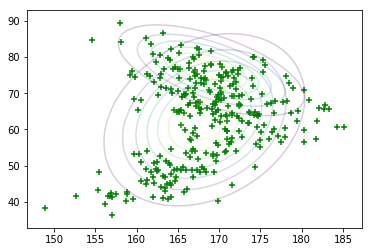

In [6]:
def log_likelihood(ds,X,pis): # 収束の判断のために対数尤度を返す関数
    ans = 0.0
    for n in range(N):
        ws = [ pis[k] * ds[k].pdf([X[0][n],X[1][n]]) for k in range(K) ]
        ans += math.log1p(sum(ws) )
        
    return ans

def one_step():
    # Eステップ
    gammas = expectation_step(distributions,samples,mixing_coefs)
    # Mステップ
    for k in range(K):
        distributions[k], mixing_coefs[k] = maximization_step(k,samples,gammas)
    
    return log_likelihood(distributions,samples,mixing_coefs)

one_step()
draw(distributions,samples)

少し二つの分布の位置がサンプルのある場所に近づいているのが分かります。

## 対数尤度が収束するまで繰り返し

対数尤度は次の式で与えられます。

$\ln p(\boldsymbol{x}_{0:N-1} | \boldsymbol{\mu}_{0:1}, \Sigma_{0:1}, \pi_{0:1}) = \sum_{n=0}^{N-1} \ln \left\{ \sum_{k=0}^{K-1} \pi_k \mathcal{N}(\boldsymbol{x}_n | \boldsymbol{\mu}_k, \Sigma_k) \right\}$

---------------------------------------------
repeat:  27
Gauss 0 : 
  share:  0.335608809928
  mean:  [ 165.06860441   49.41320004]
  cov:  [[ 30.3067068   24.43495529]
 [ 24.43495529  38.28989752]]
Gauss 1 : 
  share:  0.664391190072
  mean:  [ 169.83496672   70.10618095]
  cov:  [[ 30.90176727 -19.12949369]
 [-19.12949369  48.37831582]]


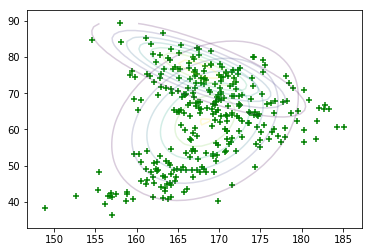

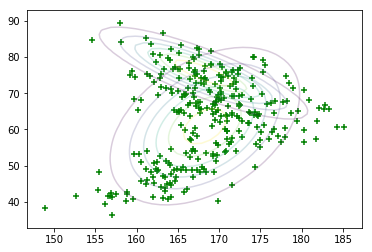

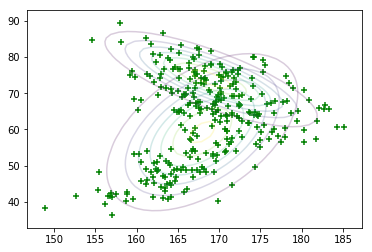

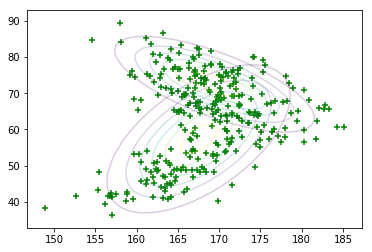

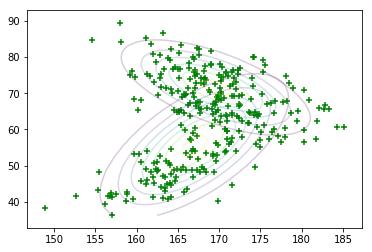

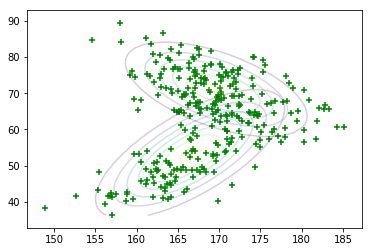

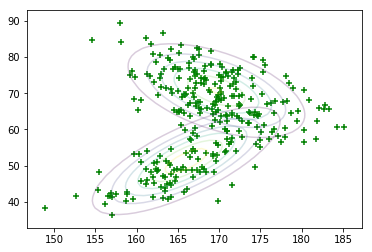

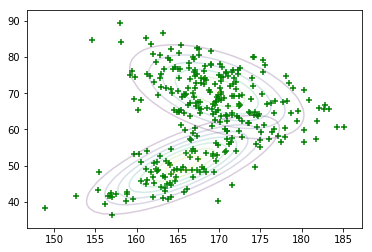

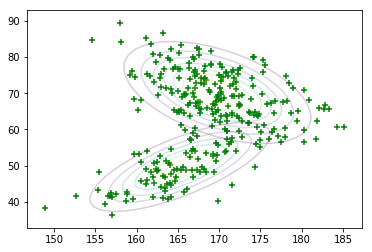

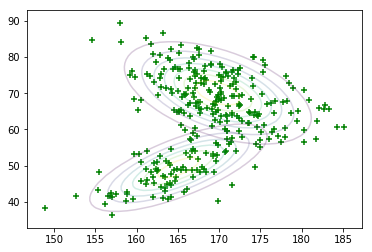

In [7]:
prev_log_likelihood = 0.0
for i in range(99):
    after_log_likelihood = one_step()
    
    if prev_log_likelihood/after_log_likelihood > 0.999: # 0.1%以上対数尤度が改善しなければ抜ける
        break 
    else:
        prev_log_likelihood = after_log_likelihood
        
    if i % 3 == 0:
        plt.figure()
        draw(distributions,samples)

plt.figure()
draw(distributions,samples)

print("---------------------------------------------")
print("repeat: ", i+1)
for k in range(K):
    print("Gauss",k,": ")
    print("  share: ", mixing_coefs[k])
    print("  mean: ", distributions[k].mean)
    print("  cov: ", distributions[k].cov)